In [1]:
import math
import base64
import io
import json
import random
from itertools import product, combinations
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import torch
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
import magicsoup as ms
from e1_co2_fixing.chemistry import CHEMISTRY

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
RUNS_DIR = THIS_DIR / "runs"

In [22]:
def load_hparams(runs_glob: str) -> pd.DataFrame:
    records = []
    for hparams_file in RUNS_DIR.glob(f"{runs_glob}/hparams.json"):
        run_dir = hparams_file.parent
        with open(hparams_file) as fh:
            hparams = json.load(fh)
        name = run_dir.name
        run = "_".join(name.split("_")[:-1])
        trial = name.split("_")[-1]
        records.append({**hparams, "run": run, "trial": trial, "name": name})

    return pd.DataFrame.from_records(records)

def load_scalars(runs_glob: str, scalars: list[tuple[str, str]]) -> pd.DataFrame:
    records = []
    for event_file in RUNS_DIR.glob(f"{runs_glob}/*.out.tfevents.*"):
        for tag, scalar in scalars:
            name = event_file.parent.name
            tf_ea = event_accumulator.EventAccumulator(str(event_file))
            tf_ea.Reload()
            for obj in tf_ea.Scalars(tag):
                records.append({
                    "name": name,
                    "scalar": scalar, 
                    "value": obj.value,
                    "step": obj.step,
                })
    return pd.DataFrame.from_records(records)

def find_diffs(df: pd.DataFrame, name="name", step="step", val="value") -> pd.DataFrame:
    records = []
    for _, df in df.groupby(name):
        s = df[val].diff(periods=1)
        records.extend(df.loc[s > 0.0, [step, val, name]].to_dict("records"))
    return pd.DataFrame.from_records(records)

## 2023-05-05 WL Training

I trained the cells to adopt the WL pathway by sucessively moving away from a complex medium to minimal medium in phases.
In each phase some genes would be added to the surviving cells and a molecule species would be removed from the media.
Each phase begins with an adaption period with a high mutation rate that linearly decreases to a natural low mutation rate
followed by a static period with no change.

In `WL_2023-05-05_18-15_0` adapt and static periods were 100 generations each.
The initial concentration of essential molecules in complex medium was 20.
I tried many times with 10 before, but I noticed that on the onset of each phase cells need some time to adapt.
It helps them if they still have some remaining molecules that they can live on for a few steps.
I think linearly decreasing the to-be-removed molecule species would also work.

I also split the WL pathway training into 7 phases.
Before, I always tried with 5 phases, but when introducing

$$
\text{methyl-FH4} + \text{CO} + \text{HS-CoA} \rightleftharpoons \text{acetyl-CoA} + \text{FH4} \quad \text{and} \quad
\text{CO2} + \text{NADPH} \rightleftharpoons \text{CO} + \text{NADP}
$$

and removing acetyl-CoA at phase 3 cells would just die.
I figured that's too much, since they also need to learn to restore NADPH at that time.
7 phases is the most careful I can do.
And indeed this time they failed much later during phase 5.
It almost died in 4, but then recovered.
I think an unfortunate split removed some a lot of high performing cells.
The failure at 5 was so abrupt, I was suspecting some systemic problem.

In [5]:
run_glob = "WL_2023-05-05_18-15_*"
scalars = [
    ("Cells/total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Other/Split", "split"),
    ("Other/Phase", "phase"),
    ("Other/MutationRate", "mutations"),
    ("Other/Score", "score"),
]

scalars_df = load_scalars(run_glob, scalars)
phases_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "phase"])
splits_df = find_diffs(scalars_df.loc[scalars_df["scalar"] == "split"])
hparams_df = load_hparams(run_glob)
hparams_df

n_adapt_gens  n_static_gens mut_scheme  init_cell_cover  split_ratio   
0         100.0          100.0     linear              0.2          0.2  \

   split_thresh_cells  split_thresh_mols                  run trial   
0                 0.7                0.2  WL_2023-05-05_18-15     0  \

                    name  
0  WL_2023-05-05_18-15_0

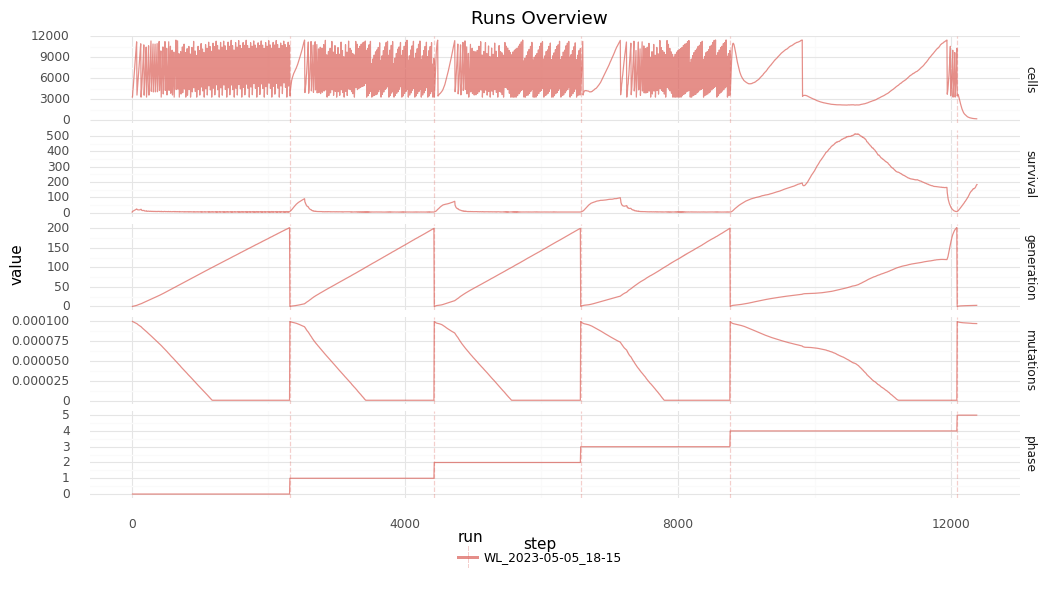

<ggplot: (8747939876411)>

In [29]:
scalars = ["cells", "survival", "generation", "mutations", "phase"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name"]], on="name")
df1 = phases_df.merge(hparams_df[["run", "trial", "name"]], on="name")

(ggplot(df)
    + geom_vline(aes(xintercept="step", color="run"), alpha=0.3, linetype="dashed", data=df1)
    + geom_line(aes(y="value", x="step", group="name", color="run"), alpha=0.7)
    + facet_grid("scalar ~ .", scales="free")
    + theme(figure_size=(12, 6), legend_position="bottom")
    + ggtitle("Runs Overview"))

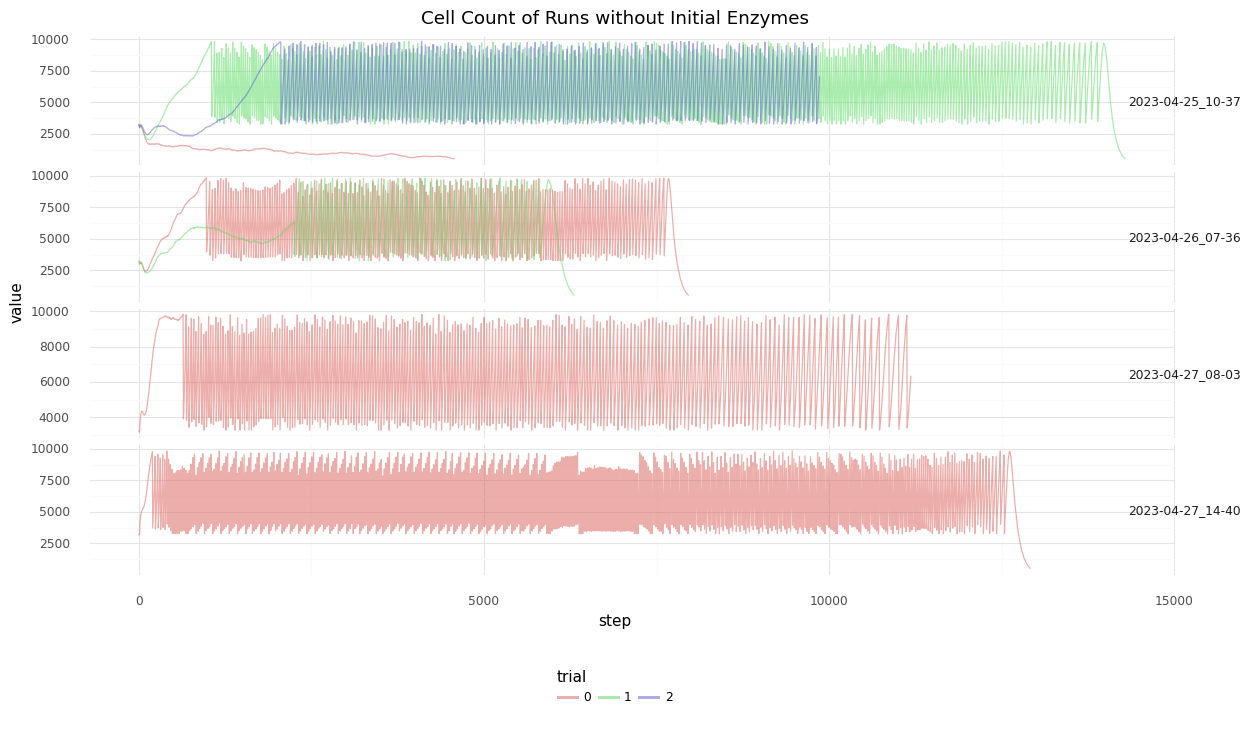

<ggplot: (8760807763665)>

In [153]:
df = pd.merge(scalars_df[scalars_df["scalar"] == "cells"], hparams_df, on="name")
df = df[df["init_enzymes"] == False]

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Cell Count of Runs without Initial Enzymes"))

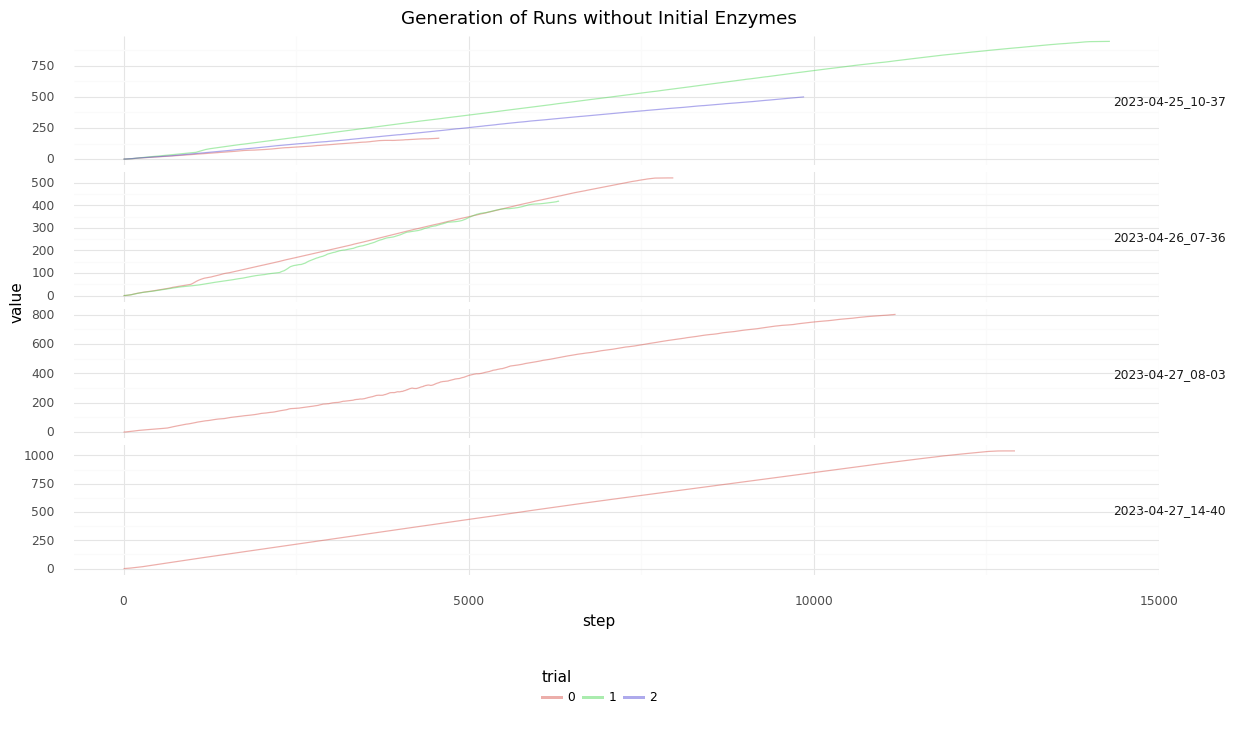

<ggplot: (8760807763635)>

In [152]:
df = pd.merge(scalars_df[scalars_df["scalar"] == "generation"], hparams_df, on="name")
df = df[df["init_enzymes"] == False]

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Generation of Runs without Initial Enzymes"))

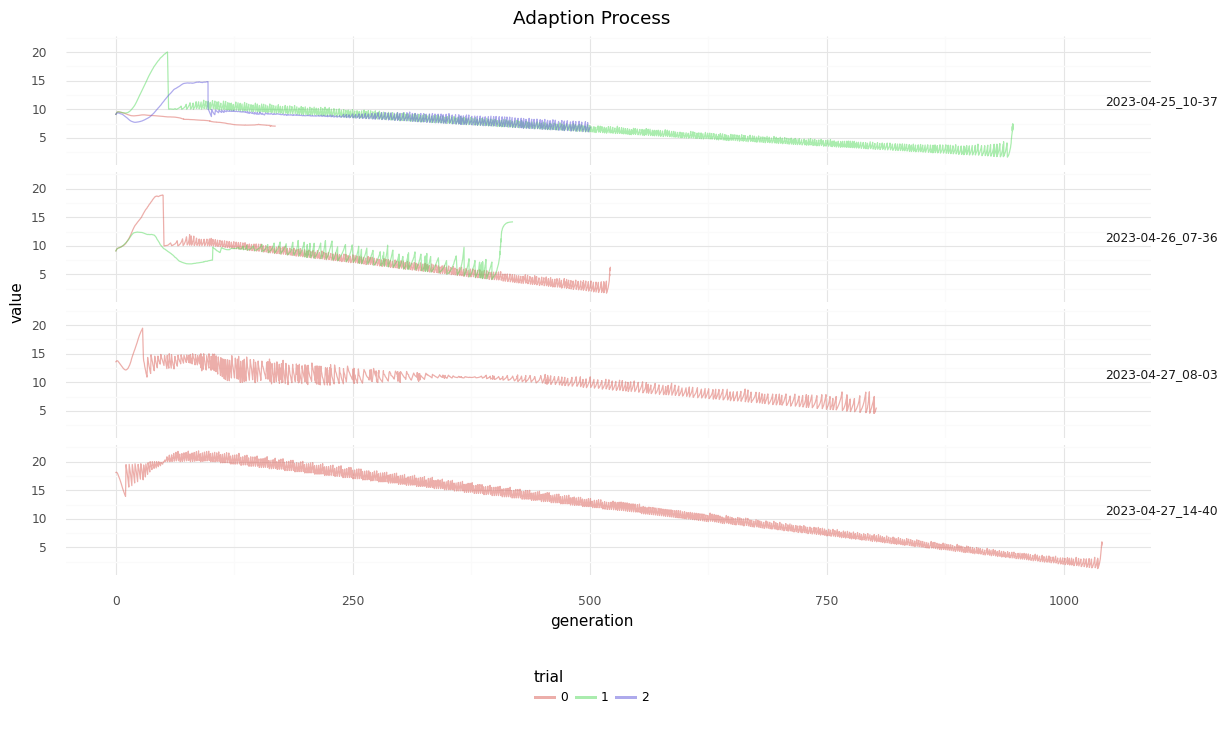

<ggplot: (8760818478408)>

In [158]:
df = hparams_df.loc[hparams_df["init_enzymes"] == False]
df = df.merge(scalars_df[scalars_df["scalar"].isin(["generation", "X[e]"])], on="name")
gens = df.loc[df["scalar"] == "generation", ["value", "step", "name"]].rename(columns={"value": "generation"})
df = df.merge(gens, on=["step", "name"])
df = df[df["scalar"] != "generation"]

(ggplot(df)
    + geom_line(aes(y="value", x="generation", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="y_free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Adaption Process"))

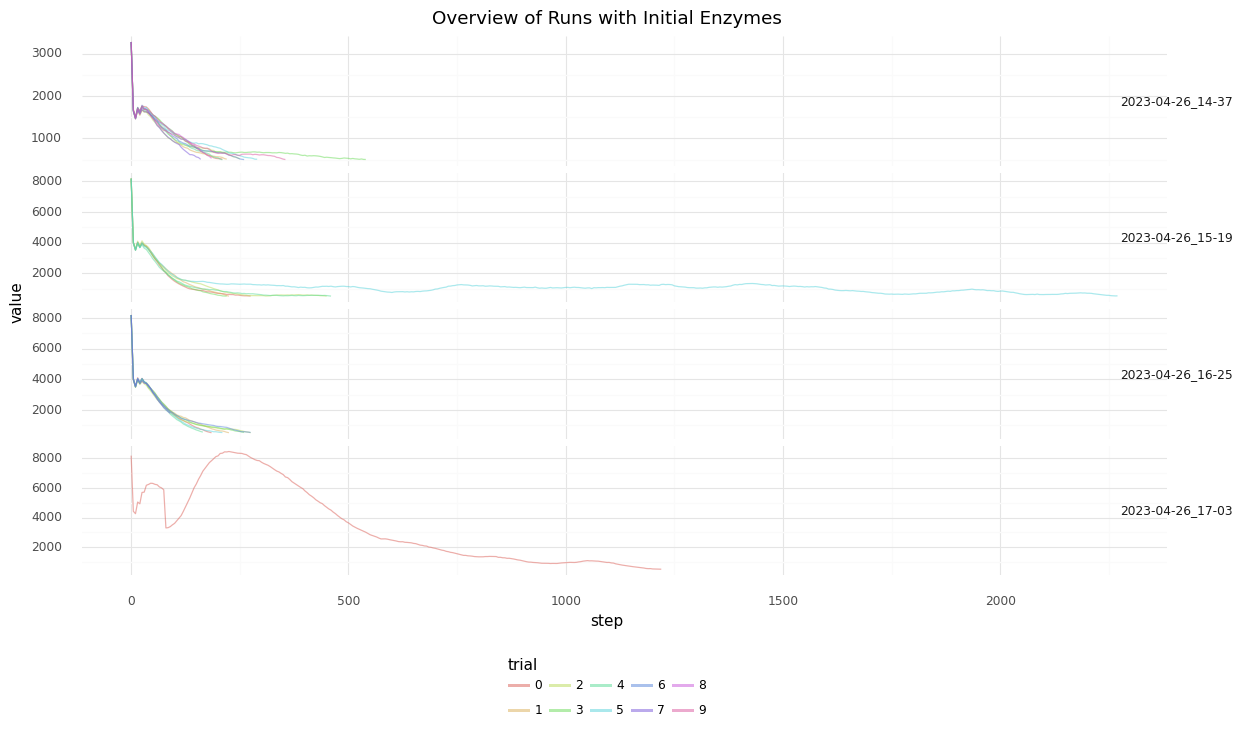

<ggplot: (8760807887095)>

In [154]:
df = pd.merge(scalars_df[scalars_df["scalar"] == "cells"], hparams_df, on="name")
df = df[df["init_enzymes"] == True]

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Cell Count of Runs with Initial Enzymes"))

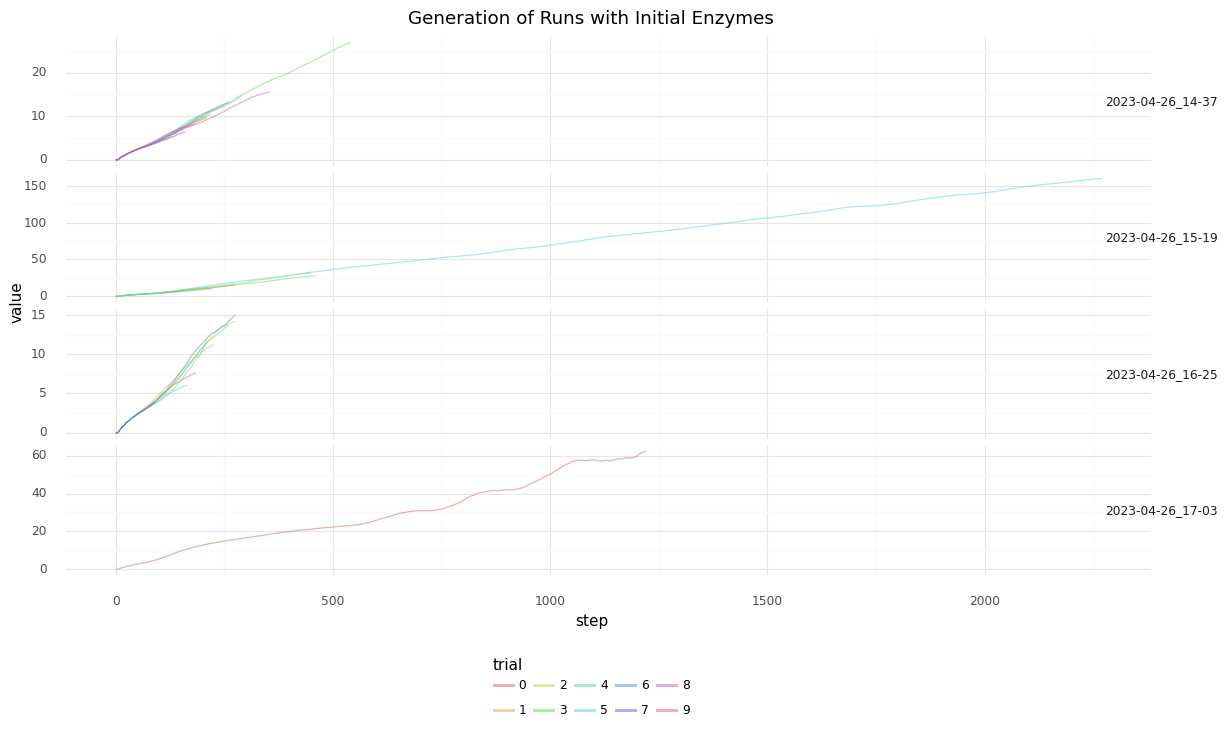

<ggplot: (8760801864461)>

In [155]:
df = pd.merge(scalars_df[scalars_df["scalar"] == "generation"], hparams_df, on="name")
df = df[df["init_enzymes"] == True]

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"), alpha=0.5)
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(14, 7), strip_text_y=element_text(angle=0), legend_position=[0.5, -.05])
    + ggtitle("Generation of Runs with Initial Enzymes"))

In [93]:
RUNS[0]

{'molmap_init': 10.0,
 'n_init_gens': 100.0,
 'n_adapt_gens': 500.0,
 'mut_scheme': 'step',
 'split_ratio': 0.2,
 'split_thresh_cells': 0.6,
 'split_thresh_mols': 0.2,
 'init_enzymes': True,
 'name': '2023-04-26_14-37_7',
 'path': PosixPath('e1_co2_fixing/runs/2023-04-26_14-37_7')}

# Run 2023-04-14_13-17_WL


In [68]:
scalars = [
    ("Cells/total[n]", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival[avg]", "survival"),
    ("Other/Split", "split")
]

records = []
for path, name in RUNS:
    tf_event_file = next(path.glob("*.out.tfevents.*"))
    tf_ea = event_accumulator.EventAccumulator(str(tf_event_file))
    tf_ea.Reload()
    for tag, label in scalars:
        for obj in tf_ea.Scalars(tag):
            records.append({
                "tag": label,
                "value": obj.value,
                "step": obj.step,
                "trial": name
            })
scalars_df = pd.DataFrame.from_records(records)

In [69]:
records = []
for trial, df in scalars_df.loc[scalars_df["tag"] == "split"].groupby("trial"):
    s = df["value"].diff(periods=1)
    records.extend(df.loc[s > 0.0, ["step", "trial"]].to_dict("records"))
splits_df = pd.DataFrame.from_records(records)
scalars_df = scalars_df[scalars_df["tag"] != "split"]

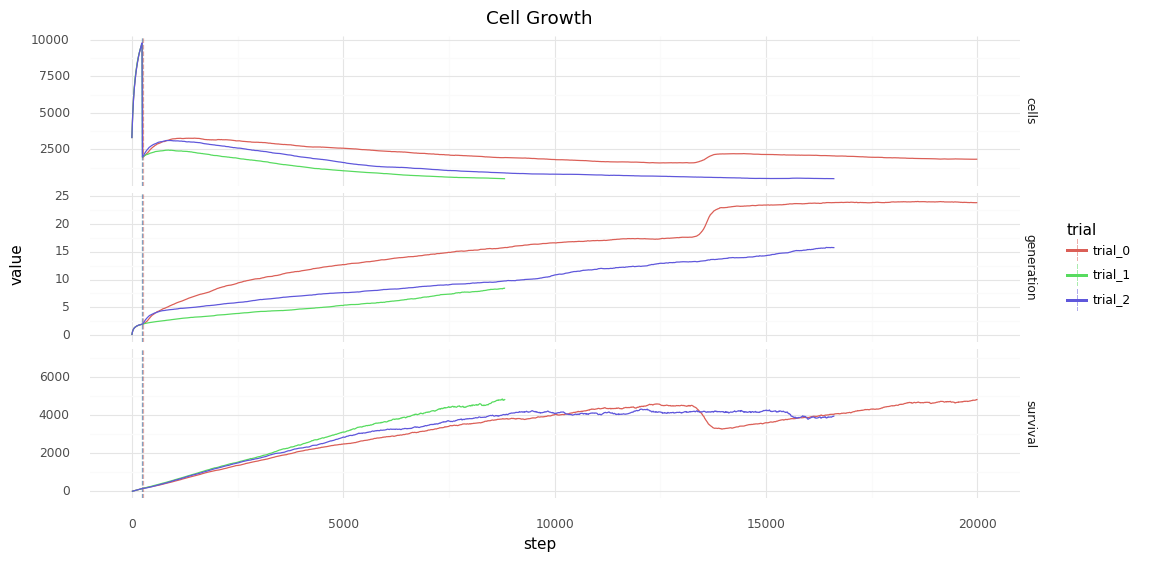

<ggplot: (8758842335812)>

In [94]:
(ggplot(scalars_df)
    + geom_vline(aes(xintercept="step", color="trial"), data=splits_df, linetype="dashed", alpha=0.5)
    + geom_line(aes(y="value", x="step", color="trial"))
    + facet_grid("tag ~ .", scales="free_y")
    + xlim(0, 20_000)
    + theme(figure_size=(12, 6))
    + ggtitle("Cell Growth"))

asd

In [71]:
world = ms.World.from_file(rundir=RUN_DIR_ROOT, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}
n_pxls = world.map_size ** 2

In [98]:
main_mols = ["CO2", "X", "Y"]
essential_mols = [d.name for d in ESSENTIAL_MOLS]

records = []
for path, trial in RUNS:
    steps = [int(d.name.split("step=")[-1]) for d in path.glob("step=*")]
    for step in steps:
        world.load_state(statedir=path / f"step={step}", ignore_cell_params=False)
        for mol in main_mols + essential_mols:
            idx = mol_2_idx[mol]
            records.append({
                "trial": trial,
                "molecule": mol,
                "step": step,
                "int": world.cell_molecules[:, idx].sum().item() / world.n_cells,
                "ext": world.molecule_map[idx].sum().item() / n_pxls
            })

molecules_df = pd.DataFrame.from_records(records)
molecules_df["total"] = molecules_df["int"] + molecules_df["ext"]

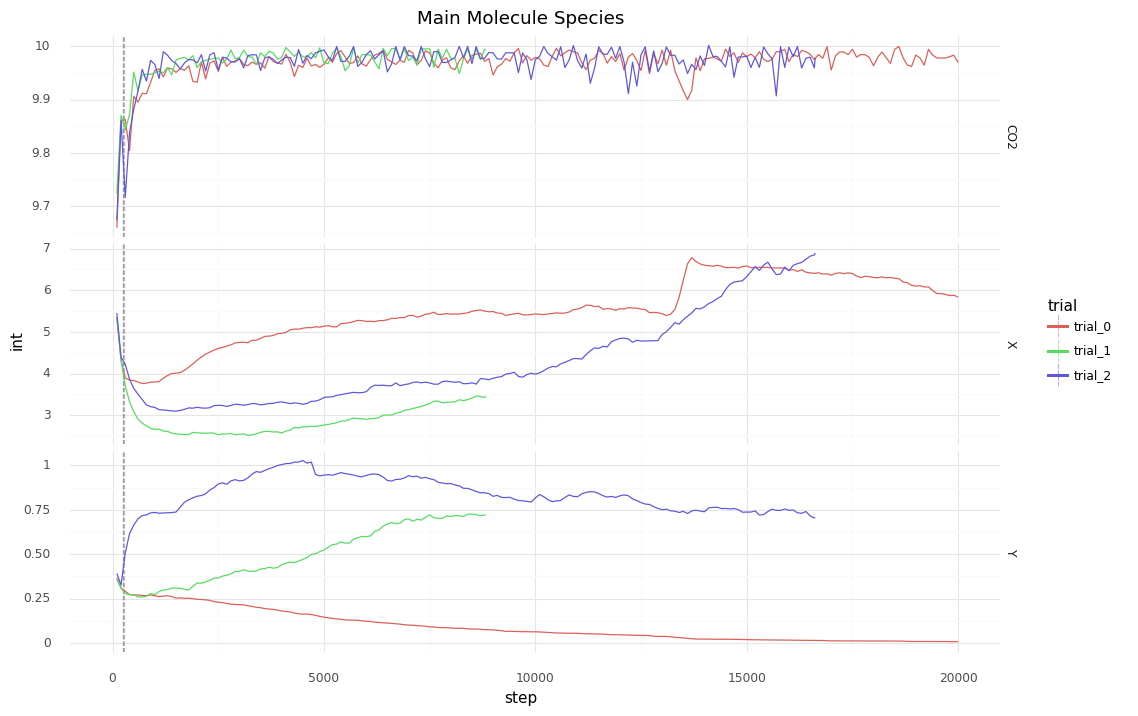

<ggplot: (8758841995484)>

In [101]:
(ggplot(molecules_df[molecules_df["molecule"].isin(main_mols)])
    + geom_vline(aes(xintercept="step", color="trial"), data=splits_df, linetype="dashed", alpha=0.5)
    + geom_line(aes(y="int", x="step", color="trial"))
    + facet_grid("molecule ~ .", scales="free_y")
    + xlim(0, 20_000)
    + theme(figure_size=(12, 8))
    + ggtitle("Main Molecule Species"))

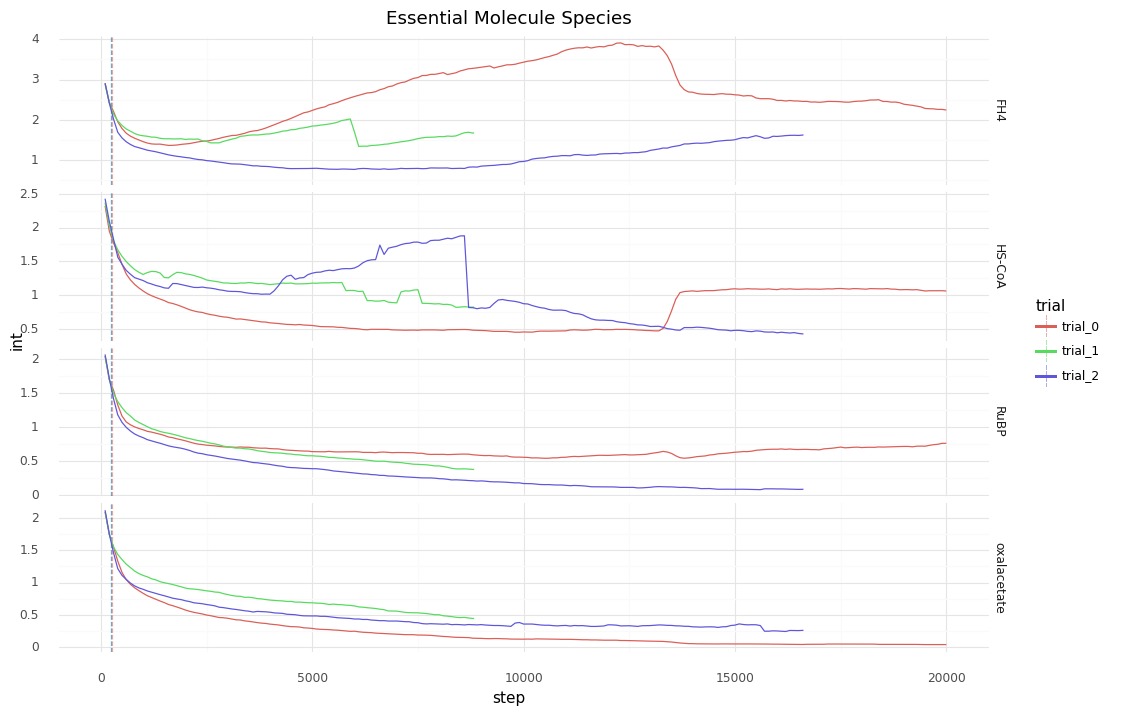

<ggplot: (8758810882021)>

In [105]:
(ggplot(molecules_df[molecules_df["molecule"].isin(essential_mols)])
    + geom_vline(aes(xintercept="step", color="trial"), data=splits_df, linetype="dashed", alpha=0.5)
    + geom_line(aes(y="int", x="step", color="trial"))
    + facet_grid("molecule ~ .", scales="free_y")
    + xlim(0, 20_000)
    + theme(figure_size=(12, 8))
    + ggtitle("Essential Molecule Species"))